In [1]:
import torch
from torch import nn
import pretrainedmodels

from utils.train import train
from utils.evaluation import evaluation
from utils.loader import get_loader, get_image_list
from utils.losses import CostSensitiveRegularizedLoss

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-04
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

In [3]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))
    sum = 0

    for i in range(len(image_list)):

        if image_list[i]['age'] in age_number:
            age_number[image_list[i]['age']] += 1
            sum += 1

    print(sum)
    return dict(age_number)


In [4]:
train_image_list, test_image_list, validate_image_list = get_image_list(
    train_size=train_size, 
    test_size=test_size, 
    val_size=val_size, 
    directory=directoryAgeDB,
)

train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=3,
)

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  34623
Test Set Length:  3298
Validation Set Length:  1649
Total:  39570


In [5]:
resnet1 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet1.last_linear = nn.Linear(
    in_features=resnet1.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet2 = pretrainedmodels.resnet18(pretrained='imagenet')
resnet2.last_linear = nn.Linear(
    in_features=resnet2.last_linear.in_features, 
    out_features=num_of_class, 
    bias=False
)
resnet1 = resnet1.to(device)
resnet2 = resnet2.to(device)

In [6]:
from pytorch_metric_learning.losses import CosFaceLoss
criteria = CosFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet1.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'cosface-aug.pth'

Epoch: 1/5, Train Loss: 27.590712719737823,  Validation Loss: 26.579018812913162
Validation Loss Decreased(inf ---> 26.579018812913162)
Epoch: 2/5, Train Loss: 25.504153051059625,  Validation Loss: 26.909641559307392
Epoch: 3/5, Train Loss: 24.592334008304835,  Validation Loss: 27.91579422583947
Epoch: 4/5, Train Loss: 23.487289372405442,  Validation Loss: 30.819516988900993
Epoch: 5/5, Train Loss: 21.00188089912668,  Validation Loss: 35.536054171048676


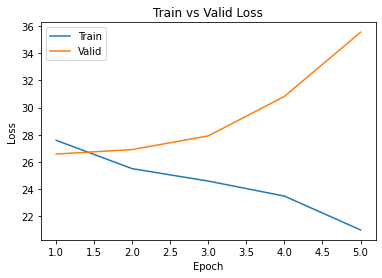

In [7]:
train(resnet1, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [8]:
resnet1.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet1, test_loader)
_ = evaluation(resnet1, train_loader)

Mean Absolute Error: 29.669496536254883
Minimum: 0.0, Maximum: 96.0, Median: 29.0
Mean Absolute Error: 29.79450035095215
Minimum: 0.0, Maximum: 96.0, Median: 30.0


In [9]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 76.00
2  No Sample
3 : 2 : 96.00
4 : 1 : 95.00
5 : 1 : 45.00
6 : 2 : 68.50
7 : 2 : 61.00
8 : 2 : 42.00
9 : 1 : 59.00
10 : 3 : 46.00
11 : 4 : 64.75
12 : 3 : 56.00
13 : 4 : 62.75
14 : 5 : 56.60
15 : 9 : 49.00
16 : 10 : 53.30
17 : 16 : 54.44
18 : 24 : 46.04
19 : 22 : 45.95
20 : 32 : 45.97
21 : 33 : 46.48
22 : 37 : 42.65
23 : 42 : 41.45
24 : 52 : 39.48
25 : 57 : 40.14
26 : 55 : 39.24
27 : 61 : 38.80
28 : 69 : 37.23
29 : 62 : 37.29
30 : 77 : 38.48
31 : 63 : 34.48
32 : 75 : 34.84
33 : 67 : 34.27
34 : 72 : 34.75
35 : 82 : 32.13
36 : 69 : 35.57
37 : 74 : 31.23
38 : 76 : 31.08
39 : 64 : 29.84
40 : 77 : 29.21
41 : 64 : 28.08
42 : 71 : 29.34
43 : 65 : 27.75
44 : 56 : 28.00
45 : 68 : 29.13
46 : 57 : 24.44
47 : 58 : 24.38
48 : 62 : 25.11
49 : 53 : 24.62
50 : 63 : 26.62
51 : 57 : 25.68
52 : 62 : 25.37
53 : 50 : 24.90
54 : 51 : 24.57
55 : 59 : 23.39
56 : 45 : 24.53
57 : 49 : 24.02
58 : 49 : 22.20
59 : 43 : 24.30
60 : 49 : 21.20
61 : 41 : 21.51
62 : 48 : 23.90
63 : 

  0%|          | 0/11541 [00:00<?, ?it/s]

Train Set Length:  11541
Test Set Length:  3298
Validation Set Length:  1649
Total:  16488
Epoch: 1/5, Train Loss: 29.32995506957337,  Validation Loss: 27.268490131084736
Validation Loss Decreased(inf ---> 27.268490131084736)
Epoch: 2/5, Train Loss: 26.09680683010227,  Validation Loss: 27.040675823505108
Validation Loss Decreased(27.268490131084736 ---> 27.040675823505108)
Epoch: 3/5, Train Loss: 24.877657418722634,  Validation Loss: 27.57297603900616
Epoch: 4/5, Train Loss: 23.278796772380453,  Validation Loss: 29.789808860191933
Epoch: 5/5, Train Loss: 18.935852711017315,  Validation Loss: 37.337444892296425


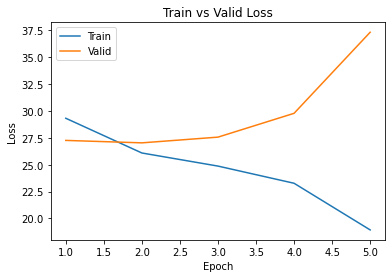

In [10]:
train_loader, test_loader, validation_loader = get_loader(
    input_size=input_size,
    train_image_list=train_image_list,
    test_image_list=test_image_list, 
    validate_image_list=validate_image_list, 
    batch_size=batch_size,
    train_augment=1,
)
criteria = CosFaceLoss(num_classes=num_of_class, embedding_size=num_of_class)
optimizer = torch.optim.Adam(resnet2.parameters(), lr=learning_rate, weight_decay=1e-1)
model_name = 'cosface.pth'
train(resnet2, optimizer, criteria, train_loader, validation_loader, num_of_epoch=5, model_name=model_name)

In [11]:
resnet2.load_state_dict(torch.load(model_name))
loss_per_class = evaluation(resnet2, test_loader)
_ = evaluation(resnet2, train_loader)

Mean Absolute Error: 20.90448760986328
Minimum: 0.0, Maximum: 81.0, Median: 18.0
Mean Absolute Error: 20.7838134765625
Minimum: 0.0, Maximum: 83.0, Median: 18.0


In [12]:
sample_per_class = findAge(test_image_list)
print('Age: Test Sample: Loss')
for i in range(1, 102):
    if sample_per_class[i] == 0:
        print(i,' No Sample')
    else:
        print(i,':', sample_per_class[i],':', format(loss_per_class[i].item()/sample_per_class[i],'.2f'))

3298
Age: Test Sample: Loss
1 : 1 : 56.00
2  No Sample
3 : 2 : 68.00
4 : 1 : 53.00
5 : 1 : 66.00
6 : 2 : 58.00
7 : 2 : 64.00
8 : 2 : 63.00
9 : 1 : 62.00
10 : 3 : 56.33
11 : 4 : 58.25
12 : 3 : 56.67
13 : 4 : 49.25
14 : 5 : 43.80
15 : 9 : 50.56
16 : 10 : 50.10
17 : 16 : 48.75
18 : 24 : 46.62
19 : 22 : 45.64
20 : 32 : 47.09
21 : 33 : 42.58
22 : 37 : 45.97
23 : 42 : 43.33
24 : 52 : 39.96
25 : 57 : 37.91
26 : 55 : 39.40
27 : 61 : 36.39
28 : 69 : 36.87
29 : 62 : 34.32
30 : 77 : 32.75
31 : 63 : 34.32
32 : 75 : 31.72
33 : 67 : 30.76
34 : 72 : 27.67
35 : 82 : 27.55
36 : 69 : 24.58
37 : 74 : 25.97
38 : 76 : 24.22
39 : 64 : 22.30
40 : 77 : 22.14
41 : 64 : 19.12
42 : 71 : 19.17
43 : 65 : 16.66
44 : 56 : 15.38
45 : 68 : 14.47
46 : 57 : 13.05
47 : 58 : 12.66
48 : 62 : 12.10
49 : 53 : 10.25
50 : 63 : 8.56
51 : 57 : 7.11
52 : 62 : 5.90
53 : 50 : 6.26
54 : 51 : 3.27
55 : 59 : 3.49
56 : 45 : 3.24
57 : 49 : 0.71
58 : 49 : 1.98
59 : 43 : 2.00
60 : 49 : 3.02
61 : 41 : 4.22
62 : 48 : 5.08
63 : 44 : 5.89
64 